# Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [40]:
from sklearn.metrics import roc_curve
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from imblearn.over_sampling import RandomOverSampler

In [4]:
plt.rc('font', size=15)

In [5]:
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Importing Input Dataset

In [6]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/5. Bank Reviews-Complaints Analysis/BankReviews.xlsx')

# Data Inspection

In [ ]:
df.head()

,Date,Stars,Reviews,BankName
0,2017-04-10,5,"Great job, Wyndham Capital! Each person was pr...",Wyndham Capital Mortgage
1,2017-02-10,5,Matthew Richardson is professional and helpful...,Wyndham Capital Mortgage
2,2017-08-21,5,We had a past experience with Wyndham Mortgage...,Wyndham Capital Mortgage
3,2017-12-17,5,We have been dealing with Brad Thomka from the...,Wyndham Capital Mortgage
4,2016-05-27,5,I can't express how grateful I am for the supp...,Wyndham Capital Mortgage


In [ ]:
df.shape

(505, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      505 non-null    datetime64[ns]
 1   Stars     505 non-null    int64         
 2   Reviews   505 non-null    object        
 3   BankName  505 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.9+ KB


In [ ]:
df.Stars.value_counts()

5    410
1     95
Name: Stars, dtype: int64

In [ ]:
df.BankName.value_counts()

North American Savings Bank       193
Guarenteed Rate Inc                81
Triumph Lending                    60
Reliance First Capital             58
Pacific Beneficial Mortgage Co     51
LoanSnap                           40
Wyndham Capital Mortgage           22
Name: BankName, dtype: int64

#### Creating a copy of the data to make necessary changes on.

In [7]:
data = df.copy()

#### 'Date' and 'BankName' are insignificant, so we are going to drop them.

In [8]:
data.drop(columns=['Date', 'BankName'], inplace=True)

# Data PreParation

#### UDF to clean the text - lowercasing, remvoving extra spaces, remvoing symbols etc.

In [9]:
def clean_text(text):
    text = text.lower() 
    text = text.strip()
    text = re.sub(r' +', ' ', text)
    text = re.sub(r"[-()\"#/@;:{}`+=~|.!?,'0-9]", "", text)
    return(text)

In [10]:
eng_stopwords = set(stopwords.words("english"))

#### UDF to remove the stop words

In [11]:
def stop_remover(text):
    text = text.apply(lambda x: " ".join(x for x in x.split() if x not in eng_stopwords))
    return(text)

In [12]:
data['Reviews'] = data['Reviews'].apply(lambda x: clean_text(x))

In [13]:
data['Reviews'] = stop_remover(data['Reviews'])

In [14]:
data.Reviews.head(10)

0    great job wyndham capital person professional ...
1    matthew richardson professional helpful helped...
2    past experience wyndham mortgage would without...
3    dealing brad thomka beginning started stressfu...
4    cant express grateful support zach provided fa...
5    pleasure working wyndham capital september fam...
6    experience mattison beyond greatly professiona...
7    patrick answered questions email immediately s...
8    loved working group people laughed phone alway...
9    great web interface loan application document ...
Name: Reviews, dtype: object

There are still many words left in the reviews which are just mentions of the respective bank name. First, we we will find all the words from bankname variable along with their acronyms.

In [15]:
bank_words = []
for sentence in list(df.BankName.value_counts().index):
  acro = ''
  for word in sentence.split():
    bank_words.append(word.lower())
    acro += word[0]
  bank_words.append(acro.lower())

In [16]:
print(bank_words)

['north', 'american', 'savings', 'bank', 'nasb', 'guarenteed', 'rate', 'inc', 'gri', 'triumph', 'lending', 'tl', 'reliance', 'first', 'capital', 'rfc', 'pacific', 'beneficial', 'mortgage', 'co', 'pbmc', 'loansnap', 'l', 'wyndham', 'capital', 'mortgage', 'wcm']


Removing words from the 'bank-words' list which are common and can be used in other context than the bank name only. So we can keep them as hey are, in the data.

In [17]:
bank_words.remove('first')
bank_words.remove('lending')

#### Removing these bank words from the corpus

In [18]:
data.Reviews = data.Reviews.apply(lambda x: " ".join(x for x in x.split() if x not in bank_words))

# Key Positive/Negative Words Tagging

#### using SentimentIntensityAnalyzer from nltk.

#### Creating a TF DTM ( Word Level Unigram )

In [ ]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,1))

In [ ]:
data_count = count_vect.fit_transform(data.Reviews)
data_count

<505x2590 sparse matrix of type '<class 'numpy.int64'>'
	with 16761 stored elements in Compressed Sparse Row format>

In [ ]:
data_dtm = pd.DataFrame(data_count.toarray(), columns=count_vect.get_feature_names())
data_dtm.head()

,aaron,aarons,ability,able,absoltely,absolute,absolutely,accept,acceptable,accepted,access,accessible,accommodate,accommodating,accomplished,account,accountant,accross,accurate,accurately,accusing,achieve,acquire,acquired,across,act,action,actual,actually,adam,adaml,adampac,adan,added,addedconsolidationit,addition,additional,address,addressed,addressresolve,...,wonderful,wonderfully,wont,word,words,work,worked,working,works,workwe,world,worry,worrying,worse,worst,worth,would,wouldn,wouldnt,wow,write,writing,written,wrong,ws,wyndham,wyndum,xx,y,year,years,yelp,yep,yes,yet,you,youi,zach,zelada,zero
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0


In [ ]:
vocab1 = count_vect.get_feature_names()

In [ ]:
SIA = SentimentIntensityAnalyzer()

In [ ]:
pos_list = []
neg_list = []
neut_list = []
for word in vocab1:
    if(SIA.polarity_scores(word)['compound']) > 0:
        pos_list.append(word)
    elif(SIA.polarity_scores(word)['compound']) < 0:
         neg_list.append(word)
    else:
         neut_list.append(word)

In [ ]:
pos_neg_df = pd.DataFrame([len(pos_list), len(neg_list), len(neut_list)], index=['positive', 'negative', 'neutral'], columns=['unique_count'])
pos_neg_df

,unique_count
positive,296
negative,156
neutral,2138


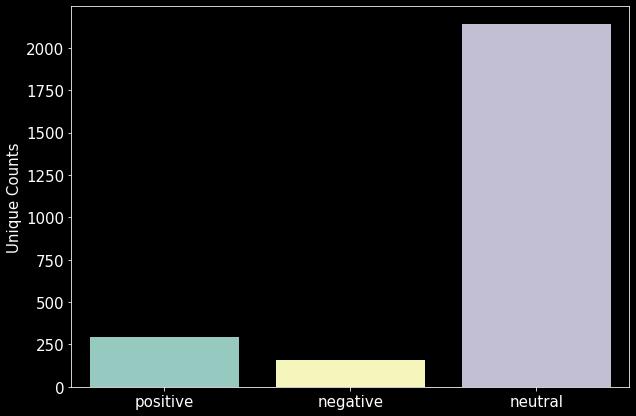

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(10,7))
  sns.barplot(x=pos_neg_df.index, y=pos_neg_df.unique_count)
  plt.ylabel('Unique Counts')

In [ ]:
pos_words = []
pos_counts = []
neg_words = []
neg_counts = []
for word in vocab1:
  if word in pos_list:
    pos_words.append(word)
    pos_counts.append(data_dtm.loc[:,word].sum())
  elif word in neg_list:
    neg_words.append(word)
    neg_counts.append(data_dtm.loc[:,word].sum())

pos_df = pd.DataFrame(pos_counts, index=pos_list, columns=['pos_counts']).sort_values(by='pos_counts', ascending=False)
neg_df = pd.DataFrame(neg_counts, index=neg_list, columns=['neg_counts']).sort_values(by='neg_counts', ascending=False)

### Top 10 Key Positive Words

In [ ]:
pos_df.head(10)

,pos_counts
recommend,156
great,139
best,99
easy,65
thanks,61
helpful,56
sure,51
thank,50
responsive,48
well,47


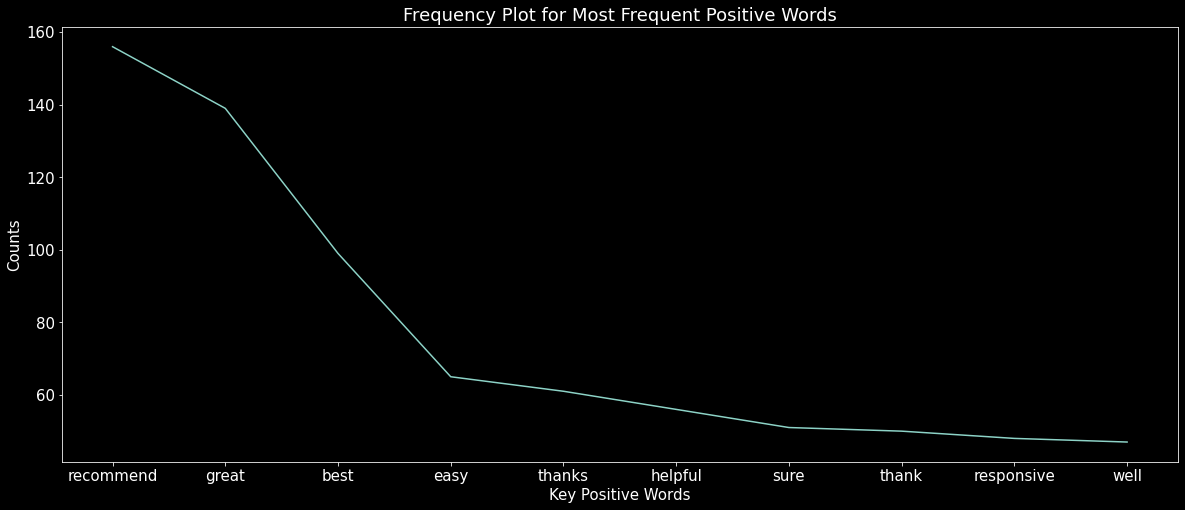

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(20,8))
  sns.lineplot(x=pos_df[0:10].index, y=pos_df[0:10].pos_counts)
  plt.xlabel('Key Positive Words')
  plt.ylabel('Counts')
  plt.title('Frequency Plot for Most Frequent Positive Words')

### Top 10 Key Negative Words

In [ ]:
neg_df.head(10)

,neg_counts
hard,40
poor,32
pay,25
stressful,24
lower,23
problem,18
mistake,17
problems,16
questioned,10
failed,10


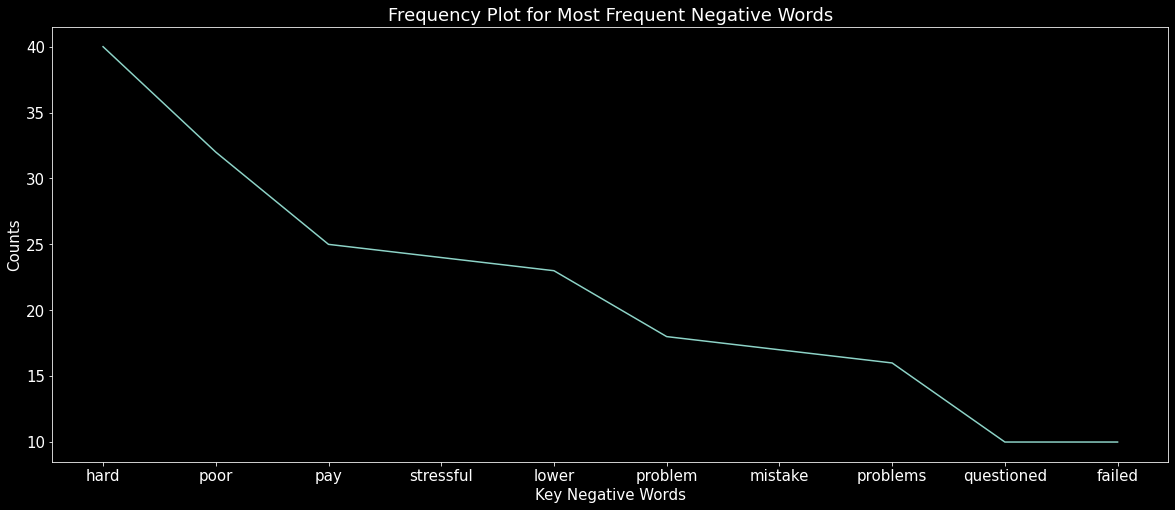

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(20,8))
  sns.lineplot(x=neg_df[0:10].index, y=neg_df[0:10].neg_counts)
  plt.xlabel('Key Negative Words')
  plt.ylabel('Counts')
  plt.title('Frequency Plot for Most Frequent Negative Words')

# Sentiment Analysis

#### using Textblob

In [ ]:
data['sentiment_value'] = data["Reviews"].apply(lambda x: TextBlob(x).sentiment.polarity )

In [ ]:
data['sentiment'] = np.where(data['sentiment_value']>0, 'Positive', np.where(data['sentiment_value']==0, 'Neutral', 'Negative'))

In [ ]:
data['sentiment'].value_counts()

Positive    454
Negative     37
Neutral      14
Name: sentiment, dtype: int64

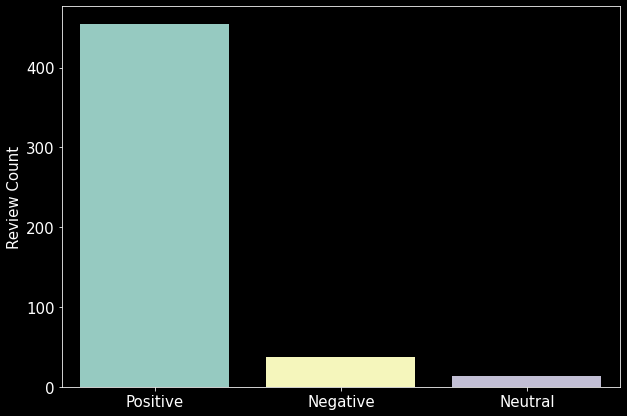

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(10,7))
  sns.barplot(x=data['sentiment'].value_counts().index, y=data['sentiment'].value_counts().values)
  plt.ylabel('Review Count', fontsize=15)
  plt.show()

### Top 5 Sample Positive Reviews

In [ ]:
for review in pd.concat([df.Reviews, data[['sentiment_value', 'sentiment']]], axis=1).sort_values(by='sentiment_value', ascending=False)[0:5].Reviews:
  print(review)


excellent service. always called and emailed to give status of our loan. very accommodating.
        

Simply awesome! Responsive and very helpful. 
        

Excellent customer service - had a great experience working with lender Marcos Maya & team!
        

John and his team were great. Best lender process I’ve had with a mortgage.
        

Great bank with great products.  Easily the best bank i've worked with.  
        


### Top 5 Sample Negative Reviews

In [ ]:
for review in pd.concat([df.Reviews, data[['sentiment_value', 'sentiment']]], axis=1).sort_values(by='sentiment_value')[0:5].Reviews:
  print(review)


bad
        

I had an awful experience with Reliance when refinancing my home.  I would not recommend them to anyone.  Among other issues, it is now 3 weeks after we closed and i am still waiting for the check that i was told that i would receive at closing!  Not weeks after closing,  DO NOT USE THIS COMPANY!!!!!
        

Called me after 60 seconds of submitting my Lending tree form. Asked if they could run some numbers by me, which I later found out was pulling my credit score without my permission. Didnt ask any specifics, just emailed a preapproval letter with a horrible rate.
        
Miserable experience. They screwed up everything imaginable and never accepted responsibility for any of their errors. I wouldnt recommend them for the purchase of a doghouse much less purchasing a new home.

Miserable experience. They screwed up everything imaginable and never accepted responsibility for any of their errors. I wouldnt recommend them for the purchase of a doghouse much less purchas

# Data Pre-Processing for Topic Modelling and Segmentation

#### Creating a Tf-Idf DTM ( Word Level Unigram )

In [ ]:
tfidf_vect = TfidfVectorizer(min_df=10, max_df=0.95,
                             ngram_range=(1, 1), 
                             stop_words=eng_stopwords)

In [ ]:
tfidf_vect.fit(data['Reviews'])

TfidfVectorizer(max_df=0.95, min_df=10,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [ ]:
train = tfidf_vect.transform(data['Reviews'])
train

<505x398 sparse matrix of type '<class 'numpy.float64'>'
	with 10844 stored elements in Compressed Sparse Row format>

In [ ]:
vocab2 = tfidf_vect.get_feature_names()
vocab2 = np.array(vocab2)

# Topic Modeling

#### using LatentDirichletAllocation

In [ ]:
lda = LatentDirichletAllocation(n_components=10, learning_method='batch', max_iter=100, random_state=12345)

In [ ]:
topics_lda = lda.fit_transform(train)
topic_words = lda.components_

In [ ]:
n_top_words = 15
topic_summaries = []
for i, topic_dist in enumerate(topic_words):
    topic_word = np.array(vocab2)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_word))

topic_summaries

['process questions home us time first recommend worked buying always refinance made work experience loan',
 'beginning looking us able dream thanks home previous list explain helped still along years refi',
 'jon loan everyone barrett awesome quick knowledgeable extremely recommend mortgage highly accurate would made answer',
 'responsive service great work easy knowledgeable always helpful dallas quickly timely good since industry got',
 'friendly job professional pleasure process throughout stephanie appreciated us well helpful great work team fast',
 'great team excellent triumph experience everything home loan thank working professional recommend lender alex time',
 'poor people alex appraisal company make mortgage loan works kory find called used expected officer',
 'rate closing would bank loan get weeks read told phone give guaranteed one information credit',
 'process entire best throughout response knowledgeable tree emailed far lending complicated mortgage companies kory ext

### Topic Models:
1. Extremely well communication
2. Friendly staff
3. Great process
4. Easy loan service
5. Entirely professional experience
6. Exceeded expectations
7. Smooth and timely
8. Responsive
9. Home loan process
10. Refinance process
11. Loan closing cost
12. Home Mortgage

# Segmentation

#### using KMeans Clustering

In [ ]:
km = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1, random_state=12345)

In [ ]:
km = km.fit(train)
km

KMeans(max_iter=100, n_clusters=4, n_init=1, random_state=12345)

In [ ]:
cluster_centers = np.array(km.cluster_centers_)

In [ ]:
# sorting the cluster centers
sorted_values = [km.cluster_centers_[i].argsort() for i in range(0,np.shape(km.cluster_centers_)[0])]

In [ ]:
# get top 10 words from that cluster
top_words = set()
for i in range(len(km.cluster_centers_)):
    top_words = set(vocab2[sorted_values[i][-15:]])
    print(top_words)

{'dallas', 'customer', 'friendly', 'best', 'helpful', 'team', 'working', 'service', 'great', 'professional', 'nasb', 'honest', 'experience', 'timely', 'excellent'}
{'get', 'weeks', 'phone', 'closing', 'made', 'told', 'time', 'home', 'jon', 'read', 'always', 'rate', 'loan', 'process', 'would'}
{'got', 'questions', 'responsive', 'recommend', 'work', 'time', 'us', 'great', 'easy', 'throughout', 'always', 'worked', 'knowledgeable', 'pleasure', 'process'}
{'would', 'amazing', 'recommend', 'team', 'mortgage', 'home', 'us', 'step', 'way', 'highly', 'process', 'worked', 'loan', 'helped', 'every'}


In [ ]:
top_words=list(top_words)

In [ ]:
data['cluster'] = km.labels_

In [ ]:
data['cluster'].value_counts()/data.shape[0]

1    0.366337
3    0.297030
2    0.207921
0    0.128713
Name: cluster, dtype: float64

In [ ]:
data['Good'] = np.where(data.Stars==5, 1, 0)
data['Bad'] = np.where(data.Stars==1, 1, 0)

In [ ]:
data[['Stars', 'sentiment_value', 'cluster', 'Good', 'Bad']].groupby('cluster').mean()

,Stars,sentiment_value,Good,Bad
cluster,,,,
0,4.753846,0.367795,0.938462,0.061538
1,3.183784,0.144601,0.545946,0.454054
2,5.000000,0.398731,1.000000,0.000000
3,4.813333,0.255470,0.953333,0.046667


### Insights:
**Segment 1** : Consist of biggest cluster of reviews (36%) basically talking about how customer's experience was great, the banking team was friendly, helpful and professional. And the service was best and working. This segment have 88% good reviews with average sentiment value being 0.37.

**Segment 2** : This segment consist 31% of the reviews among which 44% are bad reviews also this segment has the least average sentiment value i.e. 0.15 which shows that this cluster is a mix of positively and negatively intended reviews.
Briefly, this segment is about home loan process taking too much time probably, weeks and about customers being unhappy about unreasonably high closing cost for loan.

**Segment 3** : This segment has the highest average sentiment value i.e. 0.4 with 100% of the reviews being good. A small summary for this cluster of reviews will be the loan officer's team being knowledgeable and responsive and how the customer had great time throghout the process and they will recommend the bank to others.

Segment 4 : This is smallest cluster of reviews (11%) which is basically talking about how the home loan process was amazing and the loan officer and his team had helped the customers at every step. And the customers would highly recommend the bank to others.

### Troubleshoot

This data has 505 reviews about 7 different banks which might just be the main cause of some incohorent Topic Models and Clusters because every bank can have its different pros and cons which are being talked about in Reviews by the customers. So it will only be appropriate to perform Topic Modelling and Clustering individually for different banks which is quite impossible here because of small sample size.

# Predicting Stars from Reviews

## Data Pre-Processing for Data Modelling

#### Separating the Data into Features and Target

In [19]:
X = data['Reviews']
y = data['Stars']

#### Separating the Data into Train and Test

In [20]:
train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=12345)

In [ ]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(378,)
(127,)
(378,)
(127,)


#### Creating Tf-Idf DTMs ( Word Level Unigram )

In [21]:
tfidf_vect2 = TfidfVectorizer(min_df = 10, max_df=0.95,
                             ngram_range=(1, 1), 
                             stop_words=eng_stopwords)

In [22]:
train_tfidf = tfidf_vect2.fit_transform(train_x)
train_tfidf

<378x263 sparse matrix of type '<class 'numpy.float64'>'
	with 6669 stored elements in Compressed Sparse Row format>

In [23]:
test_tfidf = tfidf_vect2.transform(test_x)
test_tfidf

<127x263 sparse matrix of type '<class 'numpy.float64'>'
	with 2345 stored elements in Compressed Sparse Row format>

In [24]:
vocab3 = tfidf_vect2.get_feature_names()

In [25]:
train_dtm = pd.DataFrame(train_tfidf.toarray(), columns=vocab3)
train_dtm.head()

,able,adam,alex,almost,along,also,always,amazing,amount,another,answer,answered,answering,anyone,anything,application,around,ask,asked,available,awesome,back,banks,beginning,best,better,beyond,broker,business,buy,buying,call,called,calls,came,cant,care,chose,clear,close,...,stressful,sure,team,terms,thank,thanks,things,thought,throughout,time,timely,times,told,took,top,tree,two,understood,us,use,used,using,va,want,wanted,wasnt,way,week,weeks,well,went,whole,wife,within,without,work,worked,working,would,years
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.322078,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.217997,0.000000,0.0,0.0,0.0,0.000000,0.0,0.108999,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.144805,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.16147,0.000000,0.167725,0.0,0.0,0.261487,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.317134,0.0,0.000000,0.0,0.261487,0.0,0.000000,0.142945,0.0,0.137877,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.423489,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.432194,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.157777,0.0,0.0,0.0,0.156011,0.0,0.000000,0.181454,0.0,0.0,0.0,0.170321,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.159622,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.129925,0.154317,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.170321,0.0,0.0,0.0,0.0,0.146751,0.0,0.0,0.0,0.0,0.000000,0.0,0.142796,0.0,0.000000,0.0,0.126391,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.090273,0.0


In [ ]:
train_dtm.shape

(378, 263)

#### Target is imbalanced

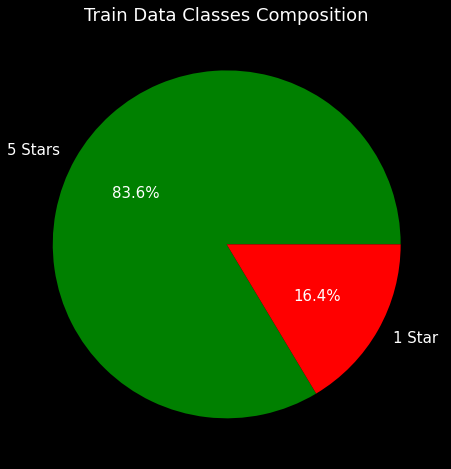

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(8,8))
  plt.pie(train_y.value_counts(), autopct='%.1f%%', labels=['5 Stars', '1 Star'], colors=['g', 'r'])
  plt.title('Train Data Classes Composition')
  plt.show()

### Balancing the Data by OverSampling

####using RandomOverSampler

In [26]:
ros = RandomOverSampler(random_state=12345)

In [27]:
train_tfidf_os, train_y_os = ros.fit_resample(train_tfidf, train_y)

In [28]:
print(train_tfidf_os.shape)
print(train_y_os.shape)

(632, 263)
(632,)


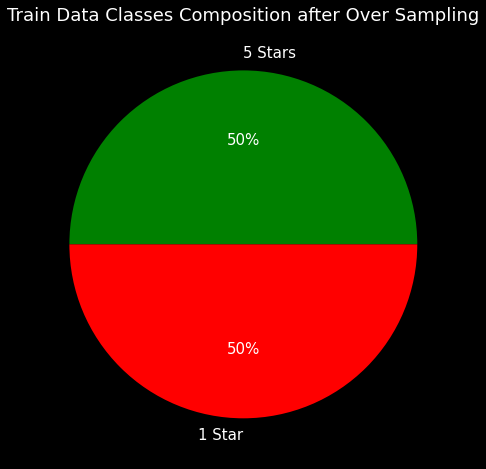

In [ ]:
with plt.style.context('dark_background'):
  plt.figure(figsize=(8,8))
  plt.pie(train_y_os.value_counts(), autopct='%d%%', labels=['5 Stars','1 Star'], colors=['g', 'r'])
  plt.title('Train Data Classes Composition after Over Sampling')
  plt.show()

Data is balanced now, So we will move onto our next and final step i.e. Data Modeling

## Data Modelling

#### using
*   Logistic Regression
*   Bernoulli's Naive Bayes
*   Linear Support Vector Machine



### Logistic Regression

In [29]:
logreg_clf = LogisticRegression(random_state=12345)

In [30]:
logreg_clf.fit(train_tfidf_os, train_y_os)

LogisticRegression(random_state=12345)

In [31]:
print('Train Accuracy :',accuracy_score(train_y_os, logreg_clf.predict(train_tfidf_os)),' | ','Test Accuracy :',accuracy_score(test_y, logreg_clf.predict(test_tfidf)))

Train Accuracy : 0.9762658227848101  |  Test Accuracy : 0.968503937007874


In [32]:
print('Train AUC:',roc_auc_score(train_y_os, logreg_clf.predict_proba(train_tfidf_os)[:,1]),' | ','Test AUC :',roc_auc_score(test_y, logreg_clf.predict_proba(test_tfidf)[:,1]))

Train AUC: 0.9949927896170485  |  Test AUC : 0.988394584139265


In [33]:
logreg_acc = accuracy_score(test_y, logreg_clf.predict(test_tfidf))
logreg_auc = roc_auc_score(test_y, logreg_clf.predict_proba(test_tfidf)[:,1])

In [ ]:
print(classification_report(test_y, logreg_clf.predict(test_tfidf)))

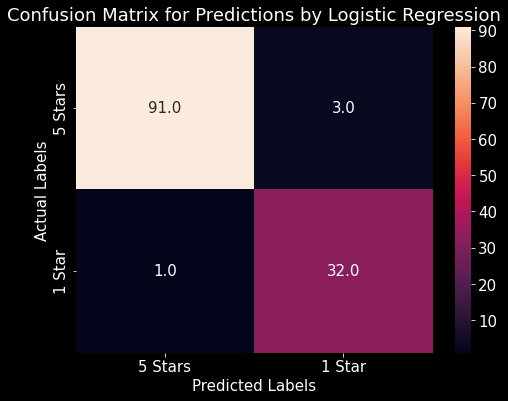

In [41]:
cm_logreg = confusion_matrix(test_y, logreg_clf.predict(test_tfidf), labels=[5,1])
with plt.style.context('dark_background'):
  plt.figure(figsize=(8,6))
  sns.heatmap(cm_logreg, annot=True,  fmt='.1f', xticklabels = ["5 Stars", "1 Star"] , yticklabels = ["5 Stars", "1 Star"] )
  plt.ylabel('Actual Labels')
  plt.xlabel('Predicted Labels')
  plt.title('Confusion Matrix for Predictions by Logistic Regression')
  plt.show()

### Bernoulli Naive Bayes

In [43]:
nb_clf = BernoulliNB()

In [44]:
nb_clf.fit(train_tfidf_os, train_y_os)

BernoulliNB()

In [45]:
print('Train Accuracy :',accuracy_score(train_y_os, nb_clf.predict(train_tfidf_os)),' | ','Test Accuracy :',accuracy_score(test_y, nb_clf.predict(test_tfidf)))

Train Accuracy : 0.8623417721518988  |  Test Accuracy : 0.9291338582677166


In [46]:
print('Train AUC:',roc_auc_score(train_y_os, nb_clf.predict_proba(train_tfidf_os)[:,1]),' | ','Test AUC :',roc_auc_score(test_y, nb_clf.predict_proba(test_tfidf)[:,1]))

Train AUC: 0.9703773433744592  |  Test AUC : 0.9732430689877498


In [50]:
nb_acc = accuracy_score(test_y, nb_clf.predict(test_tfidf))
nb_auc = roc_auc_score(test_y, nb_clf.predict_proba(test_tfidf)[:,1])

In [66]:
print(classification_report(test_y, nb_clf.predict(test_tfidf)))

              precision    recall  f1-score   support

           1       0.96      0.76      0.85        33
           5       0.92      0.99      0.95        94

    accuracy                           0.93       127
   macro avg       0.94      0.87      0.90       127
weighted avg       0.93      0.93      0.93       127



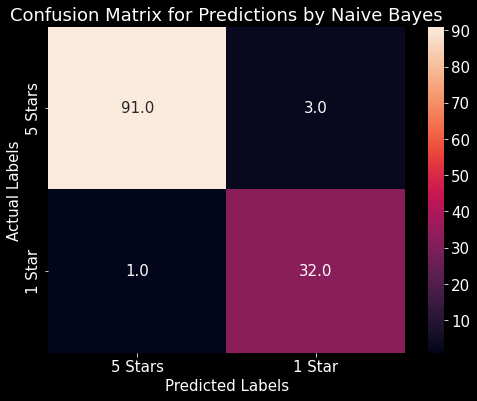

In [ ]:
cm_nb = confusion_matrix(test_y, nb_clf.predict(test_tfidf), labels=[5,1])
with plt.style.context('dark_background'):
  plt.figure(figsize=(8,6))
  sns.heatmap(cm_logreg, annot=True,  fmt='.1f', xticklabels = ["5 Stars", "1 Star"] , yticklabels = ["5 Stars", "1 Star"] )
  plt.ylabel('Actual Labels')
  plt.xlabel('Predicted Labels')
  plt.title('Confusion Matrix for Predictions by Naive Bayes')
  plt.show()

### Linear Support Vector Machine

In [57]:
lsvc = SVC(kernel='linear', gamma='auto', probability=True)

In [58]:
lsvc.fit(train_tfidf_os, train_y_os)

SVC(gamma='auto', kernel='linear', probability=True)

In [60]:
print('Train Accuracy :',accuracy_score(train_y_os, lsvc.predict(train_tfidf_os)),' | ','Test Accuracy :',accuracy_score(test_y, lsvc.predict(test_tfidf)))

Train Accuracy : 0.9889240506329114  |  Test Accuracy : 0.9448818897637795


In [59]:
print('Train AUC:',roc_auc_score(train_y_os, lsvc.predict_proba(train_tfidf_os)[:,1]),' | ','Test AUC :',roc_auc_score(test_y, lsvc.predict_proba(test_tfidf)[:,1]))

Train AUC: 0.9966051113603589  |  Test AUC : 0.9835589941972921


In [61]:
lsvc_acc = accuracy_score(test_y, lsvc.predict(test_tfidf))
lsvc_auc = roc_auc_score(test_y, lsvc.predict_proba(test_tfidf)[:,1])

In [63]:
print(classification_report(test_y, lsvc.predict(test_tfidf)))

              precision    recall  f1-score   support

           1       0.88      0.91      0.90        33
           5       0.97      0.96      0.96        94

    accuracy                           0.94       127
   macro avg       0.93      0.93      0.93       127
weighted avg       0.95      0.94      0.95       127



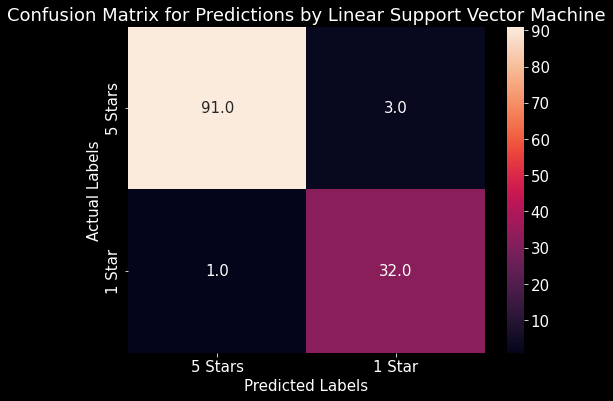

In [62]:
cm_lsvc = confusion_matrix(test_y, lsvc.predict(test_tfidf), labels=[5,1])
with plt.style.context('dark_background'):
  plt.figure(figsize=(8,6))
  sns.heatmap(cm_logreg, annot=True,  fmt='.1f', xticklabels = ["5 Stars", "1 Star"] , yticklabels = ["5 Stars", "1 Star"] )
  plt.ylabel('Actual Labels')
  plt.xlabel('Predicted Labels')
  plt.title('Confusion Matrix for Predictions by Linear Support Vector Machine')
  plt.show()

## Conclusion:

In [64]:
pd.DataFrame({'Test Accuracy': [logreg_acc, nb_acc, lsvc_acc],
             'Test AUC': [logreg_auc, nb_auc, lsvc_auc]}, index=['Logistic Regression', 'Naive Bayes', 'Linear SVC'])

,Test Accuracy,Test AUC
Logistic Regression,0.968504,0.988395
Naive Bayes,0.929134,0.973243
Linear SVC,0.944882,0.983559


Amongst all, Logistic Regression Model gave the best Test Accuracy and AUC both. So we will choose it to make the predictions.

In [65]:
test_predictions_df = pd.DataFrame({'Reviews':test_x.values,
                                    'Actual Stars':test_y.values,
                                    'Predicted Stars':logreg_clf.predict(test_tfidf)})
test_predictions_df

,Reviews,Actual Stars,Predicted Stars
0,miserable experience screwed everything imagin...,1,1
1,chris waymire loan officer worked contact some...,5,5
2,great experience working adan munoz team dlj f...,5,5
3,professional customer oriented,5,5
4,dean huge help took call work gave undivided a...,5,5
...,...,...,...
122,loan officer happy communicate committed commi...,1,1
123,cant express incredibly awesome experience wor...,5,5
124,spoke one customer service rep wasn’t willing ...,1,1
125,genna englert provided excellent service proce...,5,5
